## Using Quadratic Penalty and Log-barrier for Toy Example Segmentation

In this notebook, we will review the concepts seen about weakly-annotated segmentation using the sthe Size loss function. We utilize a different toy example that will allow us to understand and visualize the behavior of the system.

**Libraries**

In [1]:
import argparse
from pathlib import Path
from typing import Any, Callable, Tuple
from operator import itemgetter
from torch import Tensor
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn, einsum
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

**Utilities**

In [2]:
from utils.dataset import (SliceDataset)
from utils.ShallowNet import (shallowCNN)
from utils.utils import (weights_init,
                         saveImages,
                         class2one_hot,
                         probs2one_hot,
                         tqdm_,
                         dice_coef,
                         soft_size,
                         soft_centroid)
from utils.losses import (ParametrableQuadraticPenalty,
                          ParametrableLogBarrier)

**Configuring GPU**

If there is an available GPU, it is going to be contained in the variable 'device', otherwise it is going to be simply the GPU.

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

# Toy Example 2

In this example, we create a bew toy dataset of two circles to get some intuitions of quadratic penalty and the log-barrier.

**Loading the Toy dataset**

In [4]:
root_dir = 'data/TOY2/'

'''Specifying the transforms for the data during training'''
transform = transforms.Compose([
                lambda img: img.convert('L'),
                lambda img: np.array(img)[np.newaxis, ...],
                lambda nd: nd /255,
                lambda nd: torch.tensor(nd, dtype=torch.float32)])

mask_transform = transforms.Compose([
                    lambda img: np.array(img)[...],
                    lambda nd: nd / 255,
                    lambda nd: torch.tensor(nd, dtype=torch.int64)[None, ...],
                    lambda t: class2one_hot(t, K=2),
                    itemgetter(0)])

In [5]:
batch_size = 1

'''Creating dataset objects to handle all our data samples'''
train_set = SliceDataset('train', root_dir, transform=transform, mask_transform=mask_transform, augment=True, equalize=False)
val_set = SliceDataset('val', root_dir, transform=transform, mask_transform=mask_transform, equalize=False)

'''Creating dataloaders, which help us iterate over the data samples'''
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, num_workers=4, shuffle=False)

>> Created train dataset with 1000 images...
>> Created val dataset with 100 images...


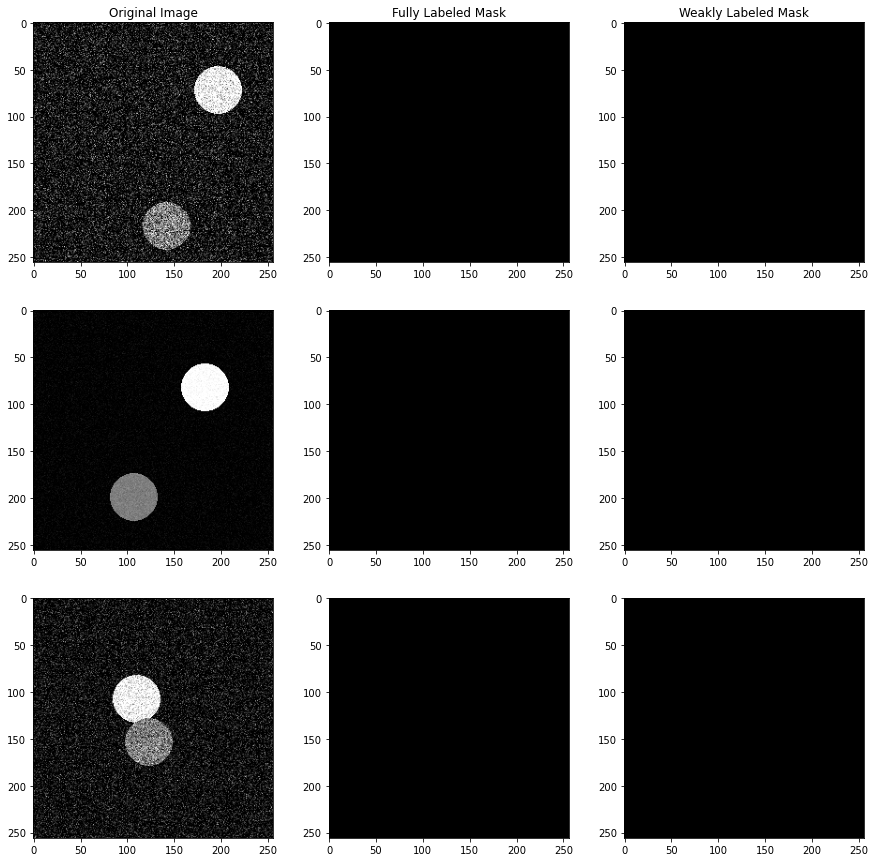

In [7]:
'''Displaying some examples'''
fig, axs = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(3):
    data = train_set[i]
    img = data['img'] #Image
    full_mask = data['full_mask'] #Fully annotated segmentation mask
    weak_mask = data['weak_mask'] #Weakly annotated segmentation mask
    axs[i,0].imshow(img.squeeze(), cmap='gray')
    axs[i,1].imshow(full_mask[1], cmap='gray')
    axs[i,2].imshow(weak_mask[1], cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,1].set_title('Fully Labeled Mask')
axs[0,2].set_title('Weakly Labeled Mask')
plt.show()

**Creating a Shallow CNN**

In [9]:
import torch.nn as nn
'''Defining a layer that contains
       |‾‾‾‾‾‾‾|     |‾‾‾‾‾‾‾‾‾‾‾‾|     |‾‾‾‾‾‾‾|
  -->  | conv  | --> |  BatchNorm | --> | PRelU | -->
       |_______|     |____________|     |_______|               '''
def convBatch(nin, nout, kernel_size=3, stride=1, padding=1, bias=False, layer=nn.Conv2d, dilation=1):
    return nn.Sequential(
        layer(nin, nout, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias, dilation=dilation),
        nn.BatchNorm2d(nout),
        nn.PReLU()
    )

'''Creating a shallow Convolutional Neural Network'''
class ShallowCNN(nn.Module):
    def __init__(self, nin, nG, nout):
        super(ShallowCNN, self).__init__()
        self.conv0 = convBatch(nin, nG * 4) #First Layer
        self.conv1 = convBatch(nG * 4, nG * 4) #Second Layer
        self.conv2 = convBatch(nG * 4, nout) #Third layer

    def forward(self, input):
        x0 = self.conv0(input)
        x1 = self.conv1(x0)
        x2 = self.conv2(x1)

        return x2

initial_kernels = 4
num_classes = 2
net = ShallowCNN(1, initial_kernels, num_classes)
net.to(device)

ShallowCNN(
  (conv0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (conv1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
)

**Setting training configurations**

In [27]:
epochs = 31 #Number of epochs to train
lr = 0.0005 #Learning rate
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999)) #Optimizer
mode = 'quadratic'
mode = 'logbarrier'

**Creating loss functions**

PyTorch have several pre-defined loss functions that we can directly use. However, there might be times when we need our own loss function, e.g. size loss. Here we show how we can create any loss function from scratch. If we construct all our objects (inputs, networks, targets, etc.) as PyTorch tensors, creating and using a loss function during backpropagation is easier. To better understand how to create **quadratic penalty** and the **log-barrier** functions, please refer to the file called "losses.py".

In [28]:
Loss_Size: Callable[[Tensor, Tensor], Tensor]
Loss_Centroid: Callable[[Tensor, Tensor], Tensor]
if mode == "quadratic":
    Loss_Size = ParametrableQuadraticPenalty(idk = [0], function=soft_size)
    Loss_Centroid = ParametrableQuadraticPenalty(idk = [0], function=soft_centroid)
elif mode == "logbarrier":
    Loss_Size = ParametrableLogBarrier(idk = [0], function=soft_size)
    Loss_Centroid = ParametrableLogBarrier(idk = [0], function=soft_centroid) 

Initialized ParametrableLogBarrier with {'idk': [0], 'function': <function soft_size at 0x7fa049d2edc0>}
Initialized ParametrableLogBarrier with {'idk': [0], 'function': <function soft_centroid at 0x7fa049d2ee50>}


**Training phase**

In [29]:
losses = []
for i in range(epochs):
    net.train()
    
    log_dice = torch.zeros((len(train_loader)), device=device)
    loss = torch.zeros((len(train_loader)), device=device)
    
    desc = f">> Training   ({i: 4d})"
    tq_iter = tqdm_(enumerate(train_loader), total=len(train_loader), desc=desc)
    
    for j, data in tq_iter:
        img = data["img"].to(device)
        full_mask = data["full_mask"].to(device)

        # Sanity tests to see we loaded and encoded the data correctly
        assert 0 <= img.min() and img.max() <= 1
        B, _, W, H = img.shape
        _, K, _, _ = full_mask.shape
        assert B == 1  # Since we log the values in a simple way, doesn't handle more
        
        true_size: Tensor = soft_size(full_mask)[..., None]  # Add an extra axis
        assert true_size.shape == (B, K, 1)  # last one is dimensionality of the value computed (size)
        true_centroid: Tensor = soft_centroid(full_mask)
        assert true_centroid.shape == (B, K, 2)  # Dimensionality is two for the centroid (two axis)

        bounds_size = einsum("bkm,u->bkmu", true_size, torch.tensor([0.9, 1.1],
                                                                    dtype=torch.float32,
                                                                    device=true_size.device))
        bounds_centroid = einsum("bkm,u->bkmu", true_centroid, torch.tensor([0.9, 1.1],
                                                                            dtype=torch.float32,
                                                                            device=true_size.device))
        
        optimizer.zero_grad()
        
        #Forward pass
        logits = net(img)
        pred_softmax = F.softmax(5 * logits, dim=1)
        pred_seg = probs2one_hot(pred_softmax)

        log_dice[j] = dice_coef(pred_seg, full_mask)[0, 1]  # 1st item, 2nd class

        combined_loss = Loss_Size(pred_softmax, bounds_size) + Loss_Centroid(pred_softmax, bounds_centroid)
        loss[j] = combined_loss.item()

        combined_loss.backward()
        optimizer.step()
        
        tq_iter.set_postfix({"DSC": f"{log_dice[:j+1].mean():05.3f}"})
        tq_iter.update(1)
    tq_iter.close()
    
    if mode == 'logbarrier':
        Loss_Size.t *= 1.1
        Loss_Centroid.t *= 1.1
    
    losses.append(loss.mean().cpu().item())
    
    if (i%5) == 0:
        saveImages(net, val_loader, 1, i, 'TOY2', mode, device)

>> Validation (  30): 100%|██████████████████████████████████████████████████████████████████| 100/100 [21.80it/s, DSC=0.990]


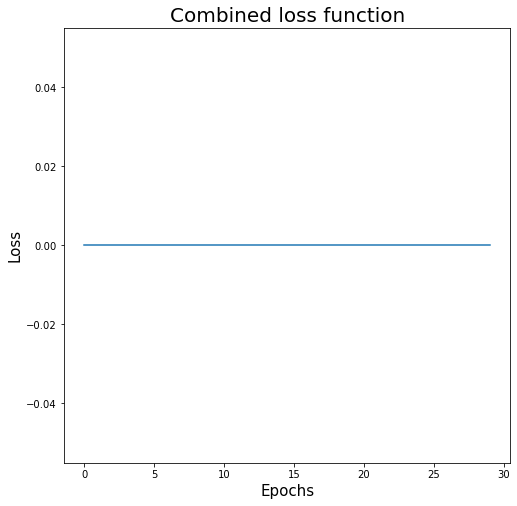

In [25]:
'''Displaying some examples'''
fig = plt.figure(0)
fig.set_figheight(8)
fig.set_figwidth(8)

plt.plot(np.arange(epochs), losses)

plt.title('Combined loss function', fontsize=20)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.show()